Ensembles are a set of elements that collectively contribute to a whole, are used for advanced refinery of models

Condorcet’s jury theorem (1784) is about an ensemble in some sense. It states that, if each member of the jury makes an independent judgement and the probability of the correct decision by each juror is more than 0.5, then the probability of the correct decision by the whole jury increases with the total number of jurors and tends to one. On the other hand, if the probability of being right is less than 0.5 for each juror, then the probability of the correct decision by the whole jury decreases with the number of jurors and tends to zero.

$$ \mu = \sum_{i=m}^{N}  {N \choose i} p^i (1-p)^{N-i}$$

N is the total number of jurors, m is the minimal number of jurors that will make a majority, m = floor(N/2) + 1, N choose i is he number of i-combinations from a set of N numbers, p is the probability of a correct decision by each individual juror, and mu is the probability of a correct decision by the entire jury

**Bootstrapping/Bootstrap Aggregation**

Theory

Sample X of size N, new sample can be made by drawing N elements from the latter, each element is equally likely to be selected (probability 1/N)

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
sns.set()
from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'

In [2]:
# for Jupyter-book, we copy data from GitHub, locally, to save Internet traffic,
# you can specify the data/ folder from the root of your cloned
# https://github.com/Yorko/mlcourse.ai repo, to save Internet traffic
DATA_PATH = "https://raw.githubusercontent.com/Yorko/mlcourse.ai/master/data/"

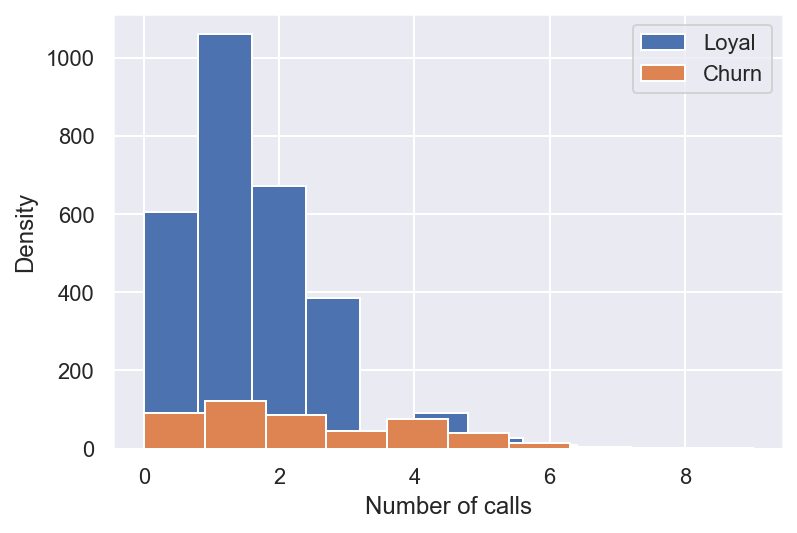

In [3]:
telecom_data = pd.read_csv(DATA_PATH + "telecom_churn.csv")

telecom_data.loc[telecom_data["Churn"] == False, "Customer service calls"].hist(
    label="Loyal"
)
telecom_data.loc[telecom_data["Churn"] == True, "Customer service calls"].hist(
    label="Churn"
)
plt.xlabel("Number of calls")
plt.ylabel("Density")
plt.legend();

In [4]:
def get_bootstrap_samples(data, n_samples):
    """Generate bootstrap samples using the bootstrap method."""
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples


def stat_intervals(stat, alpha):
    """Produce an interval estimate."""
    boundaries = np.percentile(stat, [100 * alpha / 2.0, 100 * (1 - alpha / 2.0)])
    return boundaries


# Save the data about the loyal and former customers to split the dataset
loyal_calls = telecom_data.loc[
    telecom_data["Churn"] == False, "Customer service calls"
].values
churn_calls = telecom_data.loc[
    telecom_data["Churn"] == True, "Customer service calls"
].values

# Set the seed for reproducibility of the results
np.random.seed(0)

# Generate the samples using bootstrapping and calculate the mean for each of them
loyal_mean_scores = [
    np.mean(sample) for sample in get_bootstrap_samples(loyal_calls, 1000)
]
churn_mean_scores = [
    np.mean(sample) for sample in get_bootstrap_samples(churn_calls, 1000)
]

# Print the resulting interval estimates
print(
    "Service calls from loyal: mean interval", stat_intervals(loyal_mean_scores, 0.05)
)
print(
    "Service calls from churn: mean interval", stat_intervals(churn_mean_scores, 0.05)
)

Service calls from loyal: mean interval [1.4077193  1.49473684]
Service calls from churn: mean interval [2.0621118  2.39761905]


**Bagging**

Training set X, generate samples X1,...,Xm, and for each bootstrap sample we will train a classifier a_i(x) and our final classifier will average outputs from each individual classifier
Mathematical representation

$$ a(x) = \frac{1}{M} \sum_{i=1}^{M} a_i(X)$$

Assuming a base regression problem with parameters b_1(x),...,b_n(x). Assuming y(x) to be ideal target function, error for each function is $$\epsilon_i(x)=b_i(x)-y(x), i = 1,...,n$$

Expected value for mean squared error
$$ E_x[(b_i(x)-y(x))^2] = E_x[\epsilon_i^2(x)]$$

Mean error over all regression functions
$$E_1 =  \frac{1}{n} E_x[\sum_{i}^{n} \epsilon_i^{2](x)]$$

Bagging reduces variance by decreasing difference in error, prevents overfitting, use meta-estimators such as BaggingRegressor and BaggingClassifier3

Bagging is effective on smaller datasets, on larger datasets, use bootstrap aggregation samples with small size

**Out of bag error**

No need to use cross validation on Random Forest because in ensemble techniques, error estimation takes place internally

### Random Forest

Decision trees are a good choice for the base classifier in bagging because they are quite sophisticated and can achieve zero classification error on any sample. The random subspace method reduces the correlation between the trees and thus prevents overfitting. With bagging, the base algorithms are trained on different random subsets of the original feature set.

Random subspace method
- number of instances = l, number of features = d
- choose L as the number of individual models in the ensemble
- For each model l, choose number of features dl < d, same value of dl used for all models
- For each model l, create a training set by selecting dl features at random from the whole set of d features
- Train each model.
- Applying the result ensemble model to new instance by combining results from all models in L (majority voting or aggregation)

**Algorithm**


For each k = 1,...,N
- Generate a bootstrap sample X_k
- Build a decision tree b_k on the sample X_k
    - Pick best feature according to given decision tree criteria, Split sample by feature to create new tree level. Repeat procedure until sample exhausted
    - Building tree until certain depth is reached
    - For each split, randomly pick m features from d original ones and then search for next best split only among the subset
    - $$ a(x) = \frac{1}{N} \sum_{k=1}^{N} b_k(x) $$

classification: m = √d, regression: m = d/3, recommended to build each tree until all leaves contain 1 example of classification and 5 examples for regression

**Decision Trees and Bagging**

In [5]:
# Disable warnings in Anaconda
import warnings
warnings.filterwarnings('ignore')
import numpy as np

from matplotlib import pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 10, 6
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
from sklearn.datasets import make_circles
from sklearn.ensemble import (BaggingClassifier, BaggingRegressor,
                              RandomForestClassifier, RandomForestRegressor)
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

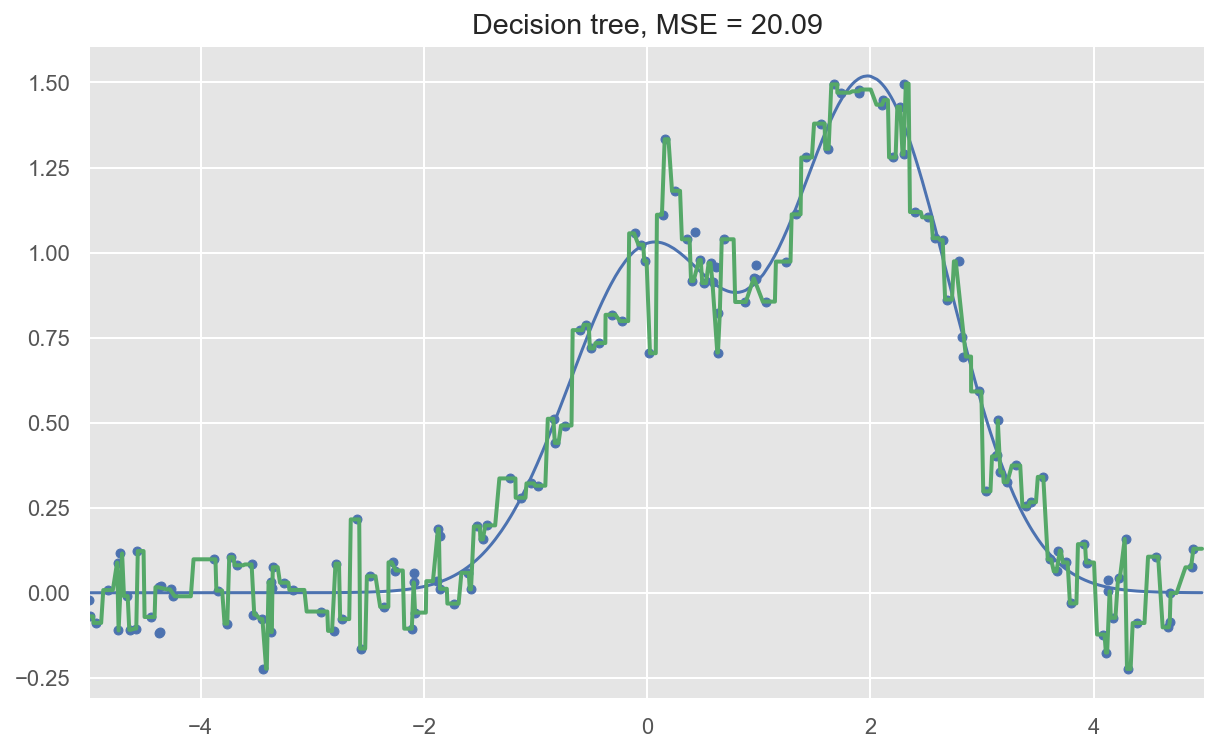

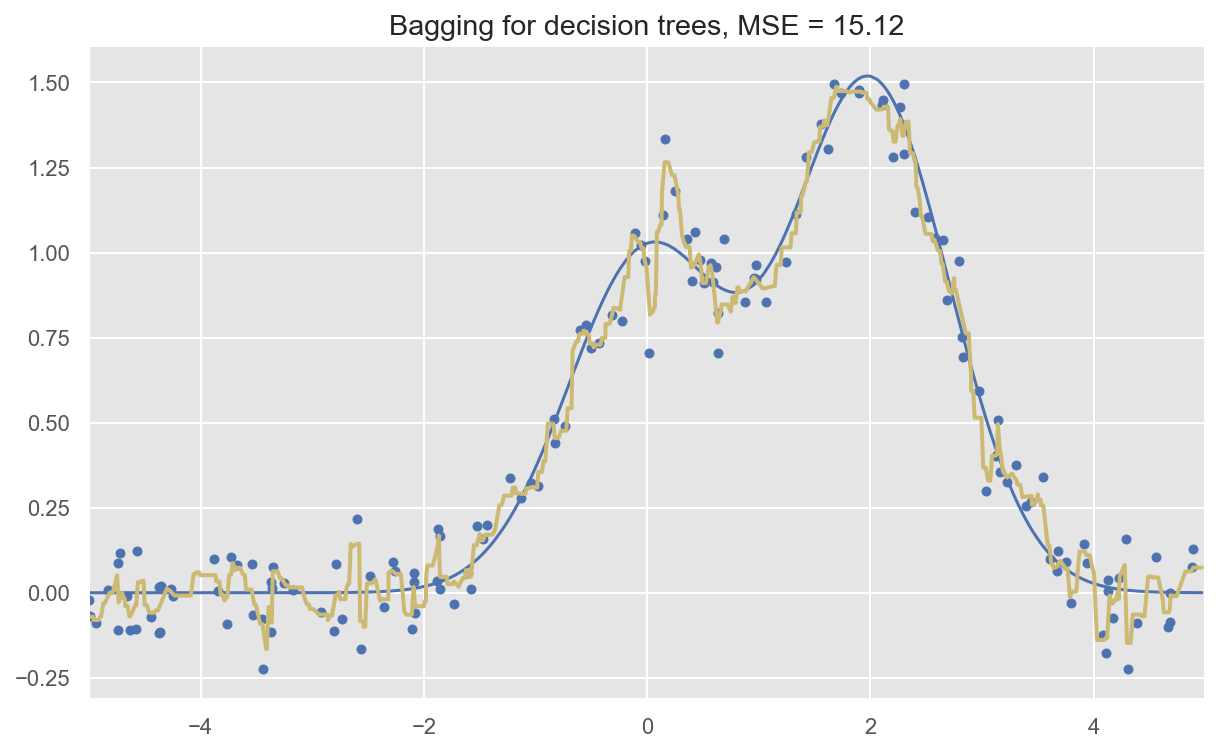

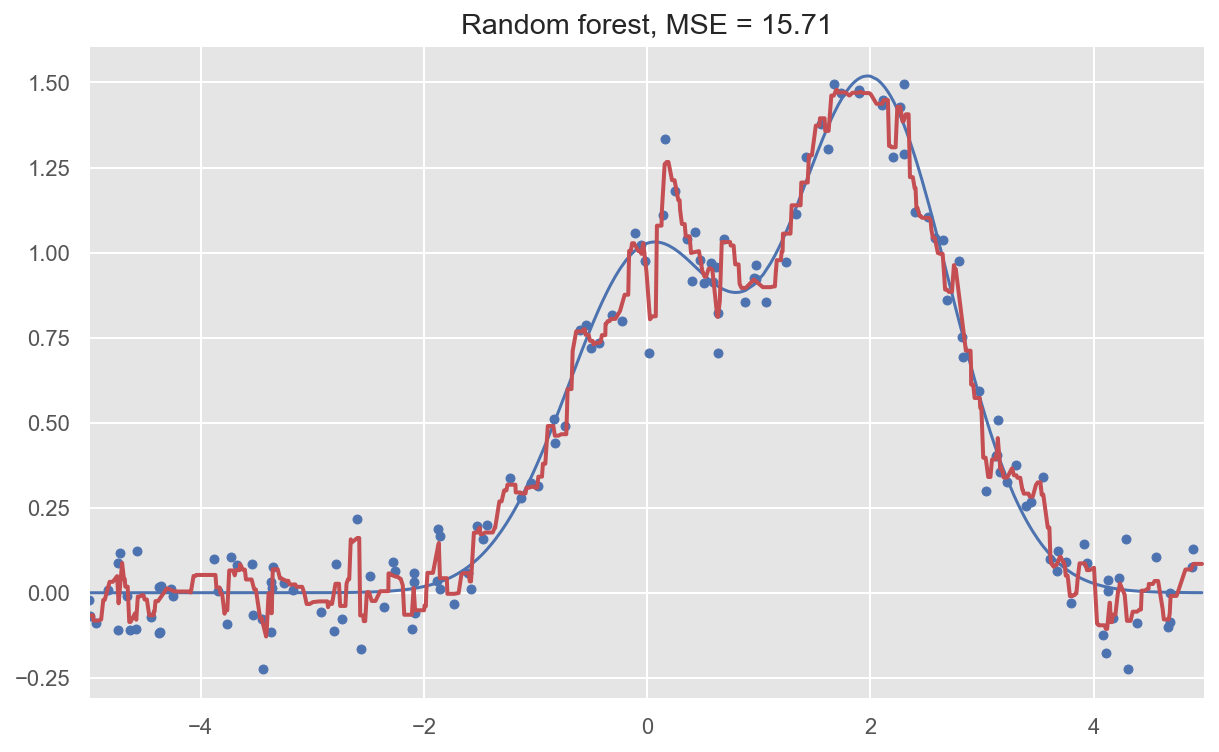

In [6]:
n_train = 150  
n_test = 1000  
noise = 0.1

# Generate data
def f(x):
    x = x.ravel()
    return np.exp(-x ** 2) + 1.5 * np.exp(-(x - 2) ** 2)

def generate(n_samples, noise):
    X = np.random.rand(n_samples) * 10 - 5
    X = np.sort(X).ravel()
    y = np.exp(-X ** 2) + 1.5 * np.exp(-(X - 2) ** 2)\
        + np.random.normal(0.0, noise, n_samples)
    X = X.reshape((n_samples, 1))

    return X, y

X_train, y_train = generate(n_samples=n_train, noise=noise)
X_test, y_test = generate(n_samples=n_test, noise=noise)

# One decision tree regressor
dtree = DecisionTreeRegressor().fit(X_train, y_train)
d_predict = dtree.predict(X_test)

plt.figure(figsize=(10, 6))
plt.plot(X_test, f(X_test), "b")
plt.scatter(X_train, y_train, c="b", s=20)
plt.plot(X_test, d_predict, "g", lw=2)
plt.xlim([-5, 5])
plt.title("Decision tree, MSE = %.2f"
          % np.sum((y_test - d_predict) ** 2))

# Bagging with a decision tree regressor
bdt = BaggingRegressor(DecisionTreeRegressor()).fit(X_train, y_train)
bdt_predict = bdt.predict(X_test)

plt.figure(figsize=(10, 6))
plt.plot(X_test, f(X_test), "b")
plt.scatter(X_train, y_train, c="b", s=20)
plt.plot(X_test, bdt_predict, "y", lw=2)
plt.xlim([-5, 5])
plt.title("Bagging for decision trees, MSE = %.2f" % np.sum((y_test - bdt_predict) ** 2));

# Random Forest
rf = RandomForestRegressor(n_estimators=10).fit(X_train, y_train)
rf_predict = rf.predict(X_test)

plt.figure(figsize=(10, 6))
plt.plot(X_test, f(X_test), "b")
plt.scatter(X_train, y_train, c="b", s=20)
plt.plot(X_test, rf_predict, "r", lw=2)
plt.xlim([-5, 5])
plt.title("Random forest, MSE = %.2f" % np.sum((y_test - rf_predict) ** 2));

whereas in random forest, best feature for split is selected randomly, in bagging all features are considered for next best split

In classification problems:

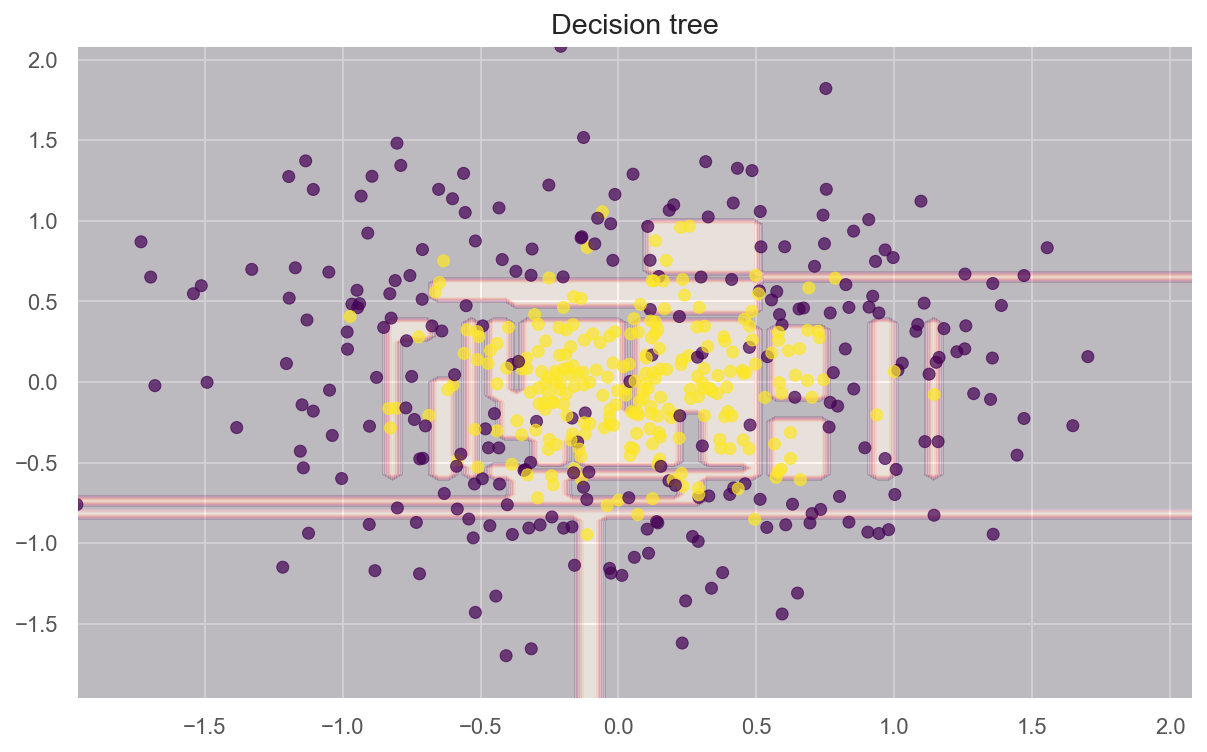

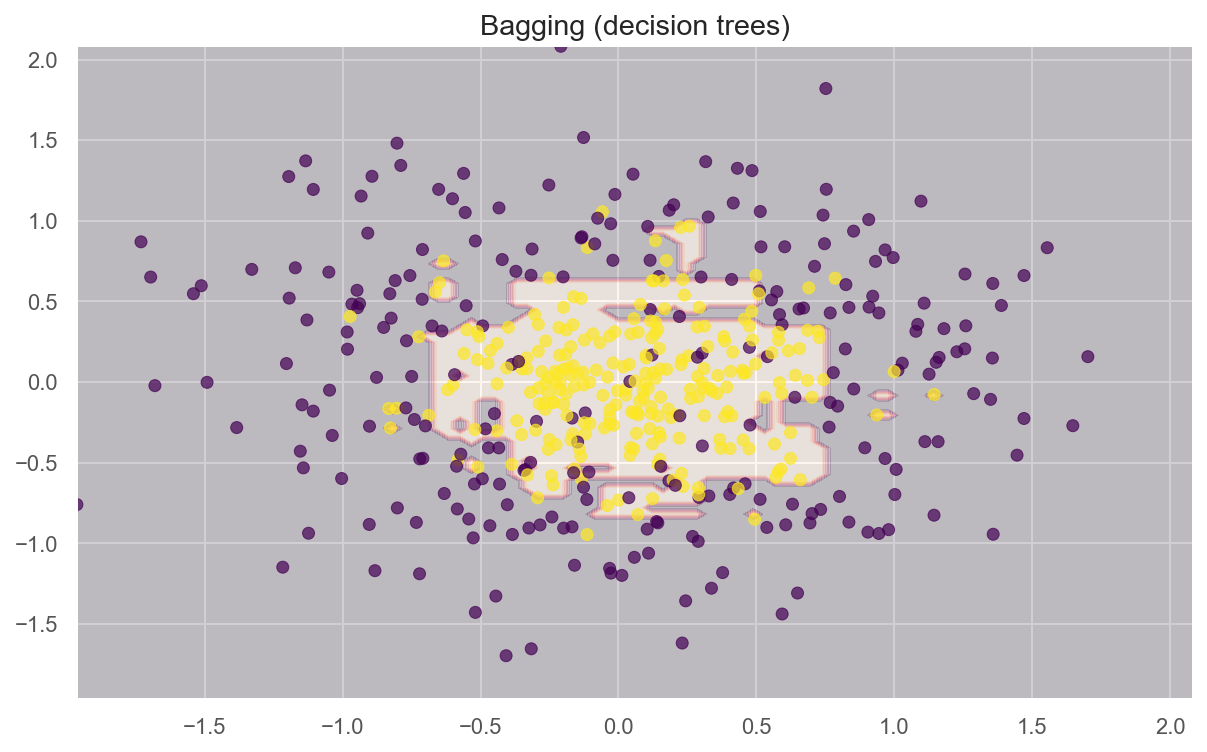

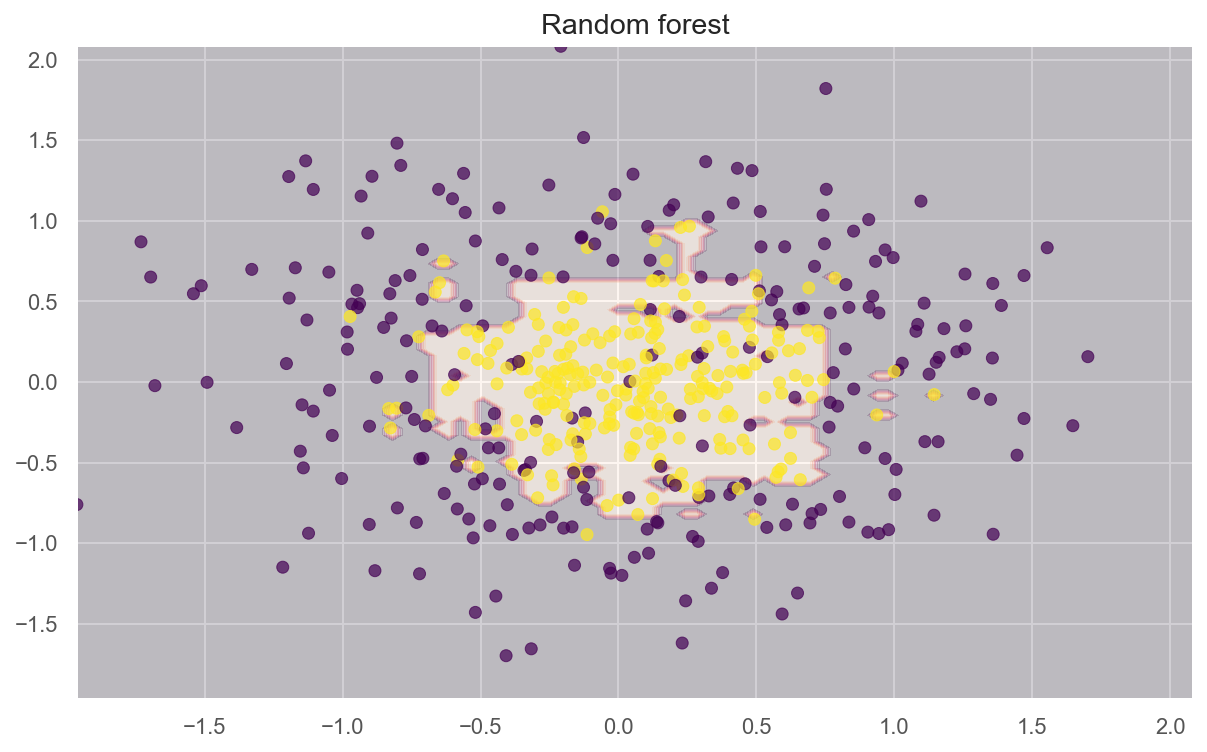

In [7]:
np.random.seed(42)
X, y = make_circles(n_samples=500, factor=0.1, noise=0.35, random_state=42)
X_train_circles, X_test_circles, y_train_circles, y_test_circles = \
    train_test_split(X, y, test_size=0.2)

dtree = DecisionTreeClassifier(random_state=42)
dtree.fit(X_train_circles, y_train_circles)

x_range = np.linspace(X.min(), X.max(), 100)
xx1, xx2 = np.meshgrid(x_range, x_range)
y_hat = dtree.predict(np.c_[xx1.ravel(), xx2.ravel()])
y_hat = y_hat.reshape(xx1.shape)
plt.contourf(xx1, xx2, y_hat, alpha=0.2)
plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis', alpha=.7)
plt.title("Decision tree")
plt.show()

b_dtree = BaggingClassifier(DecisionTreeClassifier(),
                            n_estimators=300, random_state=42)
b_dtree.fit(X_train_circles, y_train_circles)

x_range = np.linspace(X.min(), X.max(), 100)
xx1, xx2 = np.meshgrid(x_range, x_range)
y_hat = b_dtree.predict(np.c_[xx1.ravel(), xx2.ravel()])
y_hat = y_hat.reshape(xx1.shape)
plt.contourf(xx1, xx2, y_hat, alpha=0.2)
plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis', alpha=.7)
plt.title("Bagging (decision trees)")
plt.show()

rf = RandomForestClassifier(n_estimators=300, random_state=42)
rf.fit(X_train_circles, y_train_circles)

x_range = np.linspace(X.min(), X.max(), 100)
xx1, xx2 = np.meshgrid(x_range, x_range)
y_hat = rf.predict(np.c_[xx1.ravel(), xx2.ravel()])
y_hat = y_hat.reshape(xx1.shape)
plt.contourf(xx1, xx2, y_hat, alpha=0.2)
plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis', alpha=.7)
plt.title("Random forest")
plt.show()

Parameters:
Scikit Learn RandomForestClassifier and RandomForestRegressor
- n_estimators — the number of trees in the forest (default = 10)
- criterion — the function used to measure the quality of a split. Supported criteria are “mse” for the mean squared error, which is equal to variance reduction as feature selection criterion, and “mae” for the mean absolute error (default = “mse”)
- max_features — the number of features to consider when looking for the best split. You can specify the number or percentage of features, or choose from the available values: “auto” (all features), “sqrt”, “log2”. (default = “auto”)
- max_depth — the maximum depth of the tree (default means that nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples)
- min_samples_split — the minimum number of samples required to split an internal node. Can be specified as the number or as a percentage of a total number of samples (default = 2)
- min_samples_leaf — the minimum number of samples required at a leaf node(default = 1)
- min_weight_fraction_leaf — the minimum weighted fraction of the sum total of weights (of all the input samples) required to be at a leaf node. Samples have equal weight when sample_weight is not provided (default = 0)
- max_leaf_nodes — the maximum number of leaves (default = no restrictions)
- min_impurity_split — threshold for early stopping in tree growth. A node will split if its impurity is above the threshold, otherwise it is a leaf (default = 1е-7)
- bootstrap — whether bootstrap samples are used when building trees(default = True)
- oob_score — whether to use out-of-bag samples to estimate the R^2 on unseen data (default = False)
- n_jobs — the number of jobs to run in parallel for both fit and predict. If -1, then the number of jobs is set to the number of cores (default = 1)
- random_state — if int, random_state is the seed used by the random number generator; if RandomState instance, random_state is the random number generator; if None, the random number generator is the RandomState instance used by np.random (default = None)
- verbose — controls the verbosity of the tree building process (default = 0)
- warm_start — when set to True, reuse the solution of the previous call to fit and add more estimators to the ensemble, otherwise, just fit a whole new forest (default = False)


Classification has same parameters except
- criterion — the function used to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain. Note: this parameter is tree-specific (default = “gini”)
- class_weight — the weight of each class (by default all weights equal to 1, but you can create a dictionary with weights or specify it as “balanced” - uses the values of classes to automatically adjust weights inversely proportional to class frequencies in the input data or as “balanced_subsample” - the same as “balanced” except that weights are computed based on the bootstrap sample for every tree grown)

class_weight — the weight of each class (by default all weights equal to 1, but you can create a dictionary with weights or specify it as “balanced” - uses the values of classes to automatically adjust weights inversely proportional to class frequencies in the input data or as “balanced_subsample” - the same as “balanced” except that weights are computed based on the bootstrap sample for every tree grown)

In [8]:
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import (GridSearchCV, StratifiedKFold,
                                     cross_val_score)

# for Jupyter-book, we copy data from GitHub, locally, to save Internet traffic,
# you can specify the data/ folder from the root of your cloned
# https://github.com/Yorko/mlcourse.ai repo, to save Internet traffic
DATA_PATH = "https://raw.githubusercontent.com/Yorko/mlcourse.ai/master/data/"

# Load data
df = pd.read_csv(DATA_PATH + "telecom_churn.csv")

# Choose the numeric features
cols = []
for i in df.columns:
    if (df[i].dtype == "float64") or (df[i].dtype == 'int64'):
        cols.append(i)

# Divide the dataset into the input and target
X, y = df[cols].copy(), np.asarray(df["Churn"],dtype='int8')

# Initialize a stratified split of our dataset for the validation process
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize the classifier with the default parameters
rfc = RandomForestClassifier(random_state=42, n_jobs=-1)

# Train it on the training set
results = cross_val_score(rfc, X, y, cv=skf)

# Evaluate the accuracy on the test set
print("CV accuracy score: {:.2f}%".format(results.mean() * 100))

CV accuracy score: 92.50%


In [9]:
# Initialize the validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create lists to save the values of accuracy on training and test sets
train_acc = []
test_acc = []
temp_train_acc = []
temp_test_acc = []
trees_grid = [5, 10, 15, 20, 30, 50, 75, 100]

for ntrees in trees_grid:
    rfc = RandomForestClassifier(n_estimators=ntrees, random_state=42, n_jobs=-1)
    temp_train_acc = []
    temp_test_acc = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        rfc.fit(X_train, y_train)
        temp_train_acc.append(rfc.score(X_train, y_train))
        temp_test_acc.append(rfc.score(X_test, y_test))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)

train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Best CV accuracy is {:.2f}% with {} trees".format(max(test_acc.mean(axis=1))*100,
                                                        trees_grid[np.argmax(test_acc.mean(axis=1))]))

Best CV accuracy is 92.50% with 100 trees


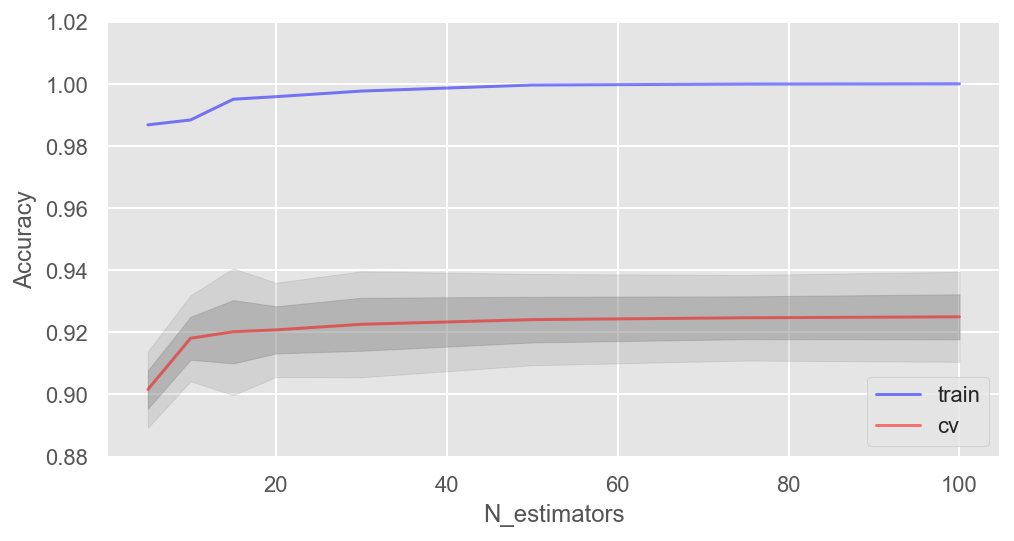

In [10]:
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(trees_grid, train_acc.mean(axis=1), alpha=0.5, color='blue', label='train')
ax.plot(trees_grid, test_acc.mean(axis=1), alpha=0.5, color='red', label='cv')
ax.fill_between(trees_grid, test_acc.mean(axis=1) - test_acc.std(axis=1),
                test_acc.mean(axis=1) + test_acc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(trees_grid, test_acc.mean(axis=1) - 2*test_acc.std(axis=1),
                test_acc.mean(axis=1) + 2*test_acc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.88,1.02])
ax.set_ylabel("Accuracy")
ax.set_xlabel("N_estimators");

Best CV accuracy is 92.44% with 24 max_depth


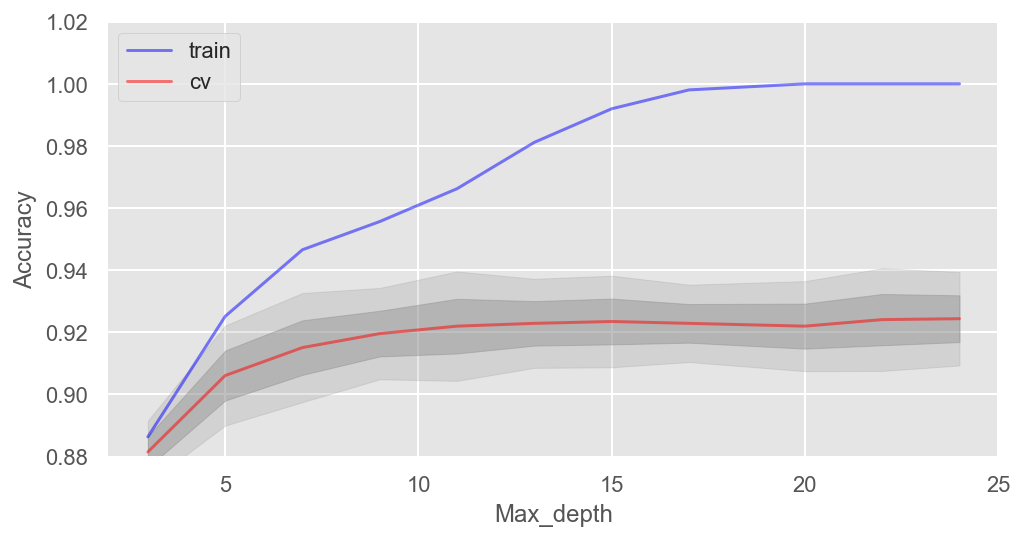

In [11]:
#adding regularization parameters to avoid overfit
# Create lists to save accuracy values on the training and test sets
train_acc = []
test_acc = []
temp_train_acc = []
temp_test_acc = []
max_depth_grid = [3, 5, 7, 9, 11, 13, 15, 17, 20, 22, 24]

for max_depth in max_depth_grid:
    rfc = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, max_depth=max_depth)
    temp_train_acc = []
    temp_test_acc = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        rfc.fit(X_train, y_train)
        temp_train_acc.append(rfc.score(X_train, y_train))
        temp_test_acc.append(rfc.score(X_test, y_test))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)

train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Best CV accuracy is {:.2f}% with {} max_depth".format(max(test_acc.mean(axis=1))*100,
                                                        max_depth_grid[np.argmax(test_acc.mean(axis=1))]))

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(max_depth_grid, train_acc.mean(axis=1), alpha=0.5, color='blue', label='train')
ax.plot(max_depth_grid, test_acc.mean(axis=1), alpha=0.5, color='red', label='cv')
ax.fill_between(max_depth_grid, test_acc.mean(axis=1) - test_acc.std(axis=1),
                test_acc.mean(axis=1) + test_acc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(max_depth_grid, test_acc.mean(axis=1) - 2*test_acc.std(axis=1),
                test_acc.mean(axis=1) + 2*test_acc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.88,1.02])
ax.set_ylabel("Accuracy")
ax.set_xlabel("Max_depth");

Parameters that correlate with regularization: **max_depth and min_samples_leaf**

Best CV accuracy is 92.50% with 1 min_samples_leaf


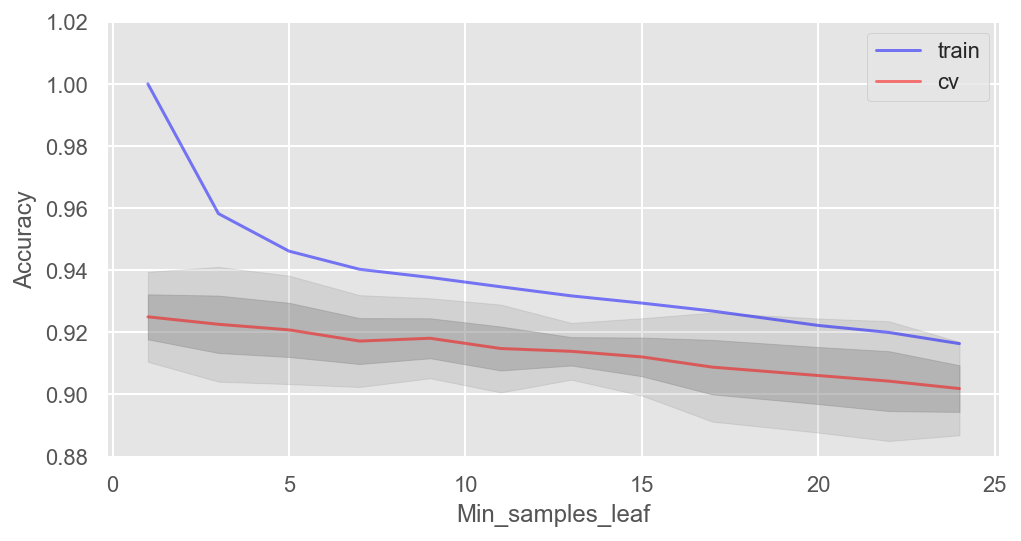

In [13]:
# Create lists to save accuracy values on the training and test sets
train_acc = []
test_acc = []
temp_train_acc = []
temp_test_acc = []
min_samples_leaf_grid = [1, 3, 5, 7, 9, 11, 13, 15, 17, 20, 22, 24]

for min_samples_leaf in min_samples_leaf_grid:
    rfc = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1,
                                 min_samples_leaf=min_samples_leaf)
    temp_train_acc = []
    temp_test_acc = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        rfc.fit(X_train, y_train)
        temp_train_acc.append(rfc.score(X_train, y_train))
        temp_test_acc.append(rfc.score(X_test, y_test))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)

train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Best CV accuracy is {:.2f}% with {} min_samples_leaf".format(max(test_acc.mean(axis=1))*100,
                                                        min_samples_leaf_grid[np.argmax(test_acc.mean(axis=1))]))

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(min_samples_leaf_grid, train_acc.mean(axis=1), alpha=0.5, color='blue', label='train')
ax.plot(min_samples_leaf_grid, test_acc.mean(axis=1), alpha=0.5, color='red', label='cv')
ax.fill_between(min_samples_leaf_grid, test_acc.mean(axis=1) - test_acc.std(axis=1),
                test_acc.mean(axis=1) + test_acc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(min_samples_leaf_grid, test_acc.mean(axis=1) - 2*test_acc.std(axis=1),
                test_acc.mean(axis=1) + 2*test_acc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.88,1.02])
ax.set_ylabel("Accuracy")
ax.set_xlabel("Min_samples_leaf");

Best CV accuracy is 92.50% with 4 max_features


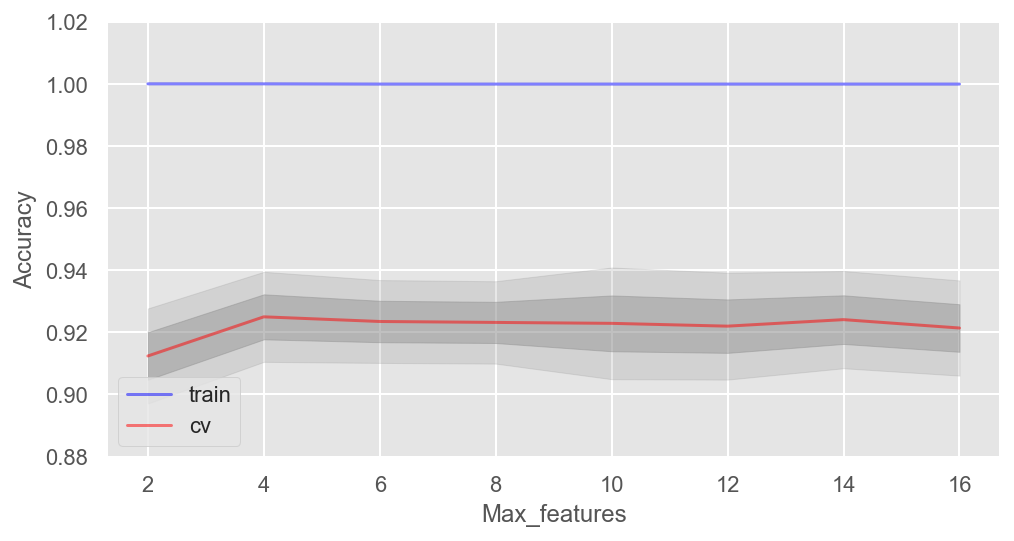

In [14]:
# Create lists to save accuracy values on the training and test sets
train_acc = []
test_acc = []
temp_train_acc = []
temp_test_acc = []
max_features_grid = [2, 4, 6, 8, 10, 12, 14, 16]

for max_features in max_features_grid:
    rfc = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1,
                                 max_features=max_features)
    temp_train_acc = []
    temp_test_acc = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        rfc.fit(X_train, y_train)
        temp_train_acc.append(rfc.score(X_train, y_train))
        temp_test_acc.append(rfc.score(X_test, y_test))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)

train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Best CV accuracy is {:.2f}% with {} max_features".format(max(test_acc.mean(axis=1))*100,
                                                        max_features_grid[np.argmax(test_acc.mean(axis=1))]))

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(max_features_grid, train_acc.mean(axis=1), alpha=0.5, color='blue', label='train')
ax.plot(max_features_grid, test_acc.mean(axis=1), alpha=0.5, color='red', label='cv')
ax.fill_between(max_features_grid, test_acc.mean(axis=1) - test_acc.std(axis=1),
                test_acc.mean(axis=1) + test_acc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(max_features_grid, test_acc.mean(axis=1) - 2*test_acc.std(axis=1),
                test_acc.mean(axis=1) + 2*test_acc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylim([0.88,1.02])
ax.set_ylabel("Accuracy")
ax.set_xlabel("Max_features");

In [15]:
# Initialize the set of parameters for exhaustive search and fit
parameters = {'max_features': [4, 7, 10, 13],
              'min_samples_leaf': [1, 3, 5, 7],
              'max_depth': [5, 10, 15, 20]}
rfc = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
gcv = GridSearchCV(rfc, parameters, n_jobs=-1, cv=skf, verbose=1)
gcv.fit(X, y)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'max_features': [4, 7, 10, 13],
                         'min_samples_leaf': [1, 3, 5, 7]},
             verbose=1)

In [16]:
gcv.best_params_, gcv.best_score_

({'max_depth': 20, 'max_features': 10, 'min_samples_leaf': 3},
 0.925596661128895)

$$ Varf(x)=p(x)\sigma^2(x) $$
$$ p(x) = Corr[T(x_1,\Theta_1(Z)),T(x_2,\Theta_2(Z))]$$

- p(x) sample correlation coefficient between any two users used in averaging
- Theta_1 and 2 of Z are randomly selected pair of trees on randomly selected elements of sample Z
- T(x,Theta_i(Z)) output of ith classifier on input vector x
- sigma term is sample variance of any randomly selected tree

Bias of random forest is same as bias of a single tree

Extremely Randomized Trees (ExtraTreesClassifier and ExtraTreesRegressor), Random Forest similar to KNN neighbors because predictions are based off labels of alike samples

For unsupervised classification use RandomTreesEmbedding, which converts the data into sparse matrices and uses binary coding with Extremely ranomized forests

Pros
- High prediction accuracy; will perform better than linear algorithms in most problems; the accuracy is comparable with that of boosting.
- Robust to outliers, thanks to random sampling.
- Doesn’t require fine-grained parameter tuning, works quite well out-of-the-box. With tuning, it is possible to achieve a 0.5–3% gain in accuracy, depending on the problem setting and data
- Efficient for datasets with a large number of features and classes.
- Rarely overfits. In practice, an increase in the tree number almost always improves the composition. But, after reaching a certain number of trees, the learning curve is very close to the asymptote.
- There are developed methods to estimate feature importance.
- Works well with missing data and maintains good accuracy even when a large part of data is missing.
Cons
- In comparison with a single decision tree, Random Forest’s output is more difficult to interpret.
There are no formal p-values for feature significance estimation.
- Performs worse than linear methods in the case of sparse data: text inputs, bag of words, etc.
- Unlike linear regression, Random Forest is unable to extrapolate. But, this can be also regarded as an advantage because outliers do not cause extreme values in Random Forests.
- Prone to overfitting in some problems, especially, when dealing with noisy data.
- In the case of categorical variables with varying level numbers, random forests favor variables with a greater number of levels. The tree will fit more towards a feature with many levels because this gains greater accuracy.
- Takes up significant amount of memory

### Feature Importance

In tree models, the higher the feature is, the more it contributes to the result (information gain and number of total nodes created)

 The former method is often called permutation importance. The latter method is used in sklearn.

**Permutation importance**
- average reduction in accuracy caused by excluding a variable is importance score (the greater the reduction, the greater the score)


Sklearn permutation importance uses Gini impurity using a formula, calculates it for each node


In [20]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.datasets import load_iris

iris = load_iris()
data = iris["data"]
target = iris["target"]

In [21]:
data = pd.DataFrame(data, columns=iris["feature_names"])
data.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [22]:
target = pd.Series(target).map({0: 0, 1: 0, 2: 1})

In [23]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=3, max_depth=3, random_state=17)
rfc.fit(data, target);

In [24]:
tree_list = rfc.estimators_

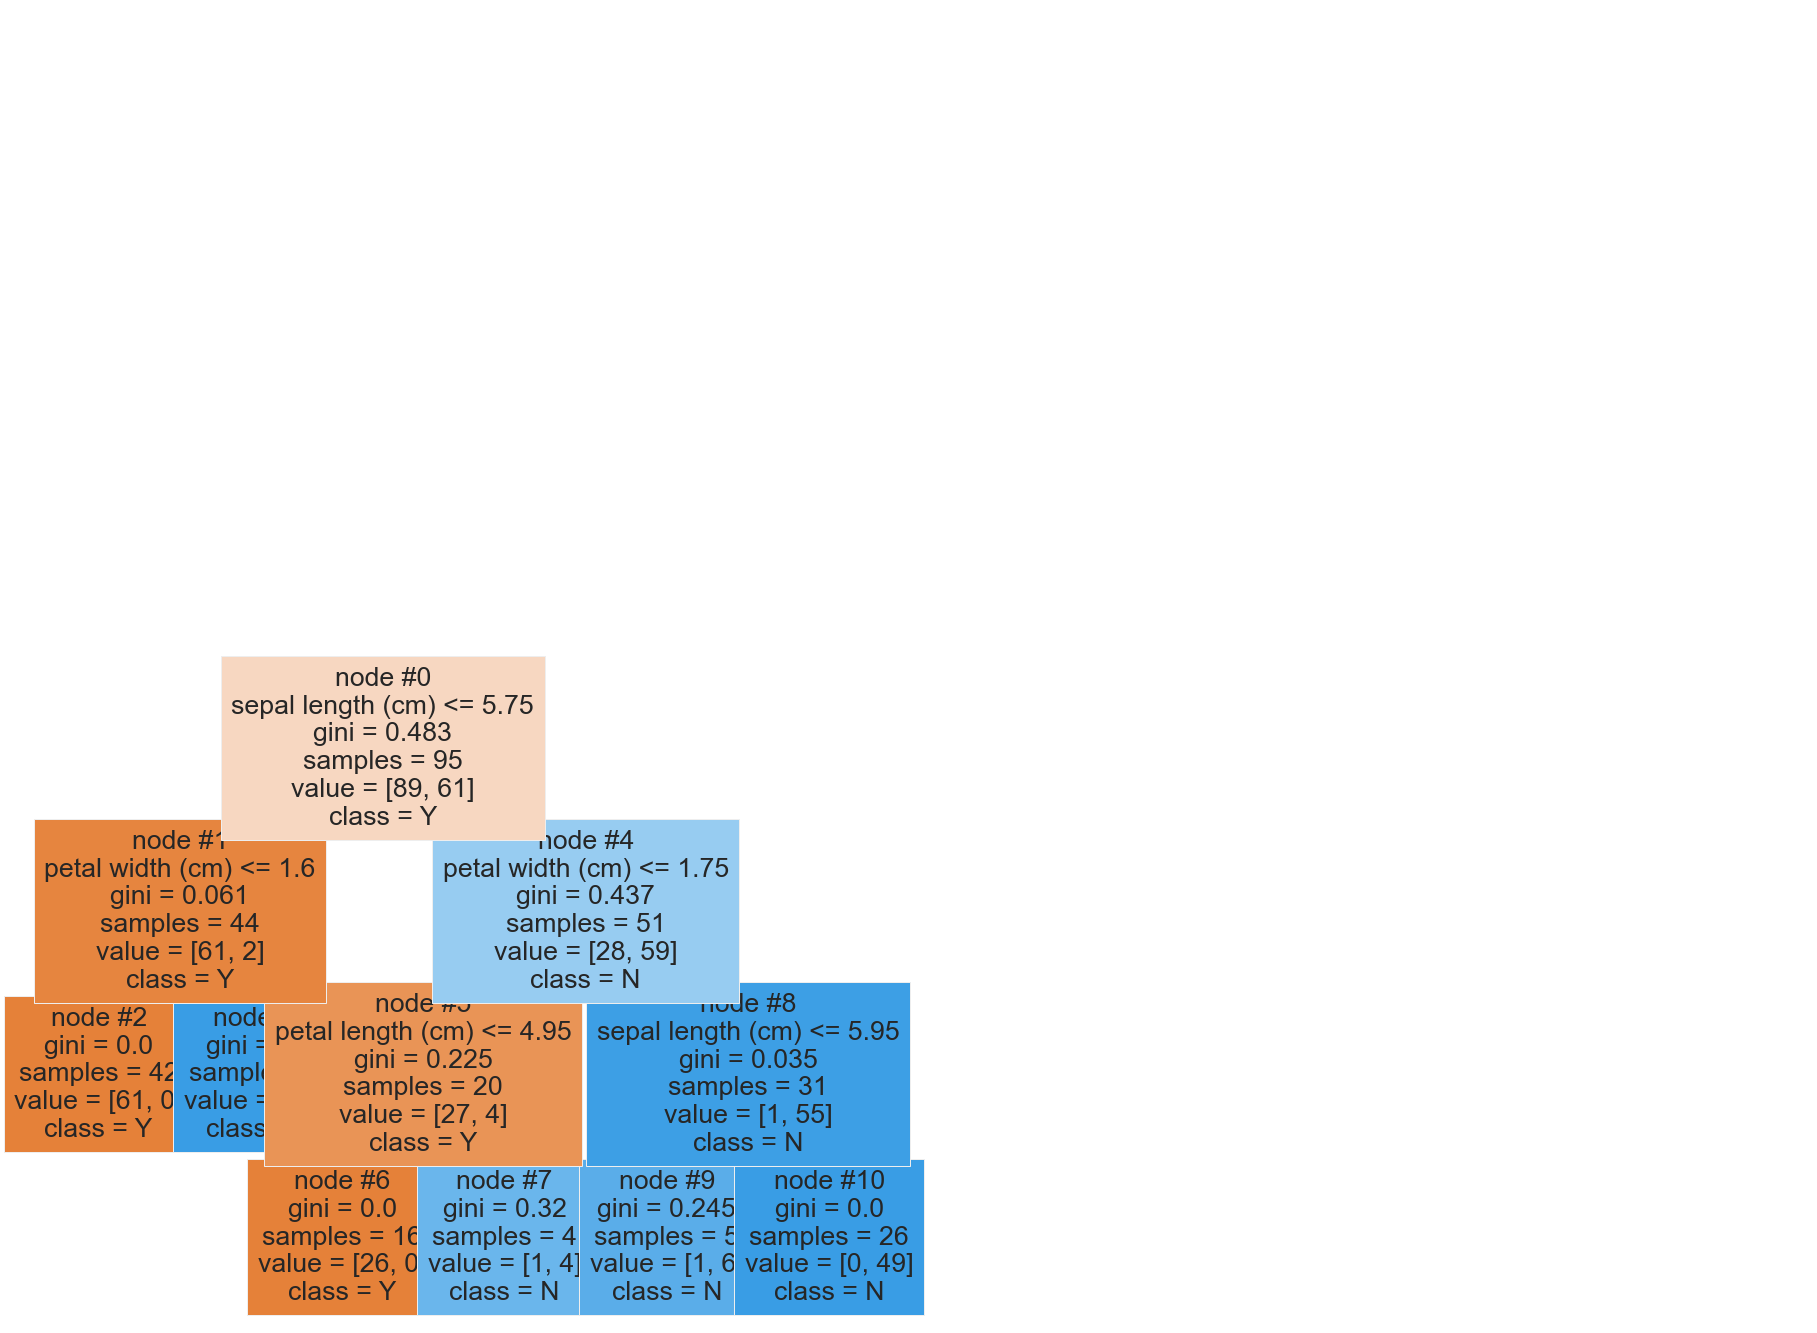

In [25]:
from sklearn import tree

plt.figure(figsize=(16, 12))
tree.plot_tree(
    tree_list[0],
    filled=True,
    feature_names=iris["feature_names"],
    class_names=["Y", "N"],
    node_ids=True,
);

In [26]:
print(iris["feature_names"])
print(rfc.feature_importances_)

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
[0.14857187 0.01324612 0.36155096 0.47663104]


**Practical Example**

In [27]:
from sklearn.ensemble import RandomForestRegressor

In [28]:
# for Jupyter-book, we copy data from GitHub, locally, to save Internet traffic,
# you can specify the data/ folder from the root of your cloned
# https://github.com/Yorko/mlcourse.ai repo, to save Internet traffic
DATA_PATH = "https://raw.githubusercontent.com/Yorko/mlcourse.ai/master/data/"

Feature ranking:
1. Staff 0.183150 
2. Value for money 0.147704 
3. Shared space condition 0.128188 
4. Extra services 0.116819 
5. Customer Co-creation 0.105748 
6. General conditions & conveniences 0.088730 
7. Shared kitchen condition 0.074776 
8. Check-in and check-out 0.061881 
9. Hostel booking 0.053899 
10. Room condition 0.039105 


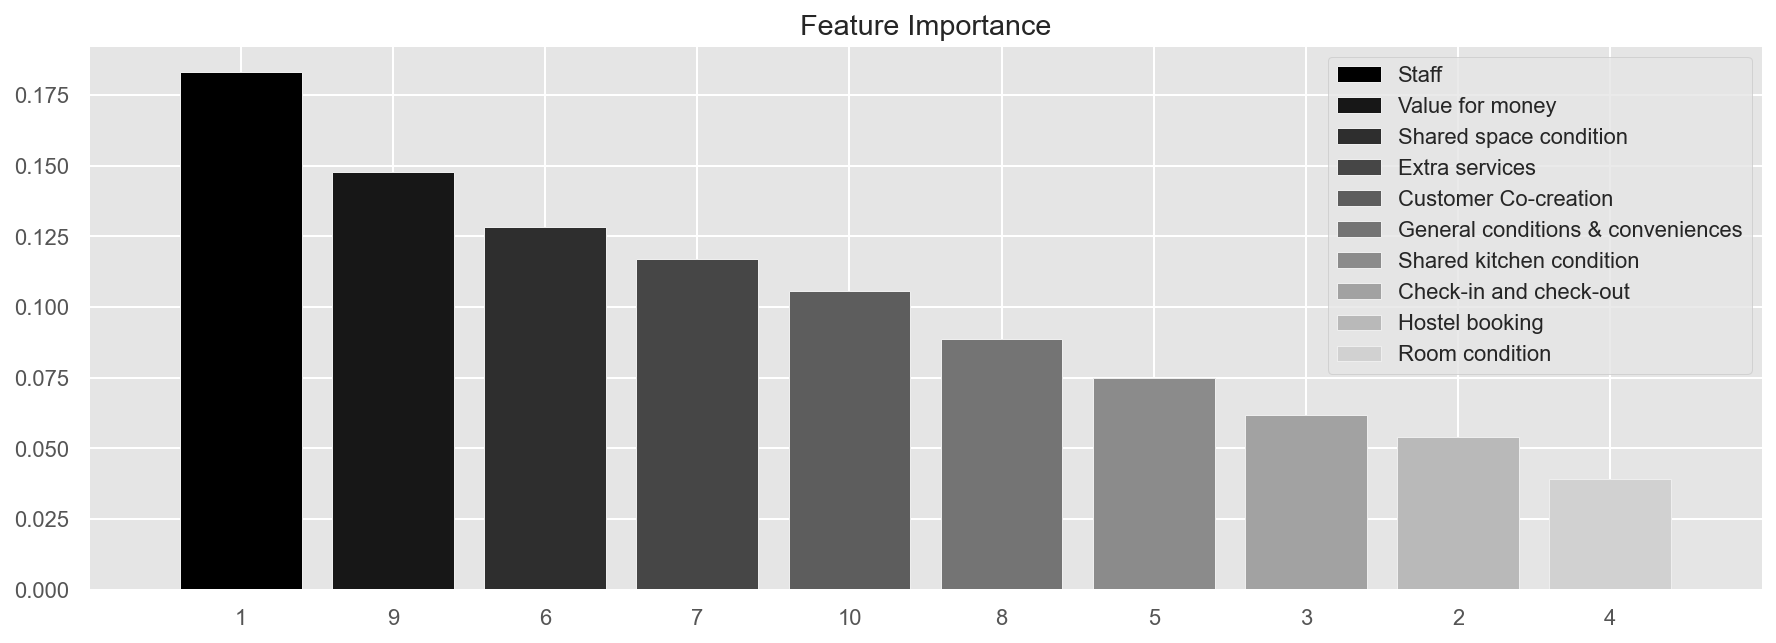

In [29]:
hostel_data = pd.read_csv(DATA_PATH + "hostel_factors.csv")
features = {
    "f1": u"Staff",
    "f2": u"Hostel booking",
    "f3": u"Check-in and check-out",
    "f4": u"Room condition",
    "f5": u"Shared kitchen condition",
    "f6": u"Shared space condition",
    "f7": u"Extra services",
    "f8": u"General conditions & conveniences",
    "f9": u"Value for money",
    "f10": u"Customer Co-creation",
}

forest = RandomForestRegressor(n_estimators=1000, max_features=10, random_state=0)

forest.fit(hostel_data.drop(["hostel", "rating"], axis=1), hostel_data["rating"])
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]
# Plot the feature importancies of the forest
num_to_plot = 10
feature_indices = [ind + 1 for ind in indices[:num_to_plot]]

# Print the feature ranking
print("Feature ranking:")

for f in range(num_to_plot):
    print(
        "%d. %s %f "
        % (f + 1, features["f" + str(feature_indices[f])], importances[indices[f]])
    )
plt.figure(figsize=(15, 5))
plt.title(u"Feature Importance")
bars = plt.bar(
    range(num_to_plot),
    importances[indices[:num_to_plot]],
    color=([str(i / float(num_to_plot + 1)) for i in range(num_to_plot)]),
    align="center",
)
ticks = plt.xticks(range(num_to_plot), feature_indices)
plt.xlim([-1, num_to_plot])
plt.legend(bars, [u"".join(features["f" + str(i)]) for i in feature_indices]);

**Practice Task**

In [31]:
# Disable warnings in Anaconda
import warnings

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [32]:
from matplotlib import rcParams

rcParams["figure.figsize"] = 11, 8

In [33]:
def fill_nan(table):
    for col in table.columns:
        table[col] = table[col].fillna(table[col].median())
    return table

In [34]:
# for Jupyter-book, we copy data from GitHub, locally, to save Internet traffic,
# you can specify the data/ folder from the root of your cloned
# https://github.com/Yorko/mlcourse.ai repo, to save Internet traffic
DATA_PATH = "https://raw.githubusercontent.com/Yorko/mlcourse.ai/master/data/"

data = pd.read_csv(DATA_PATH + "credit_scoring_sample.csv", sep=";")
data.head()

,SeriousDlqin2yrs,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
0,0,64,0,0.249908,0,0,8158.0,0.0
1,0,58,0,3870.000000,0,0,NaN,0.0
2,0,41,0,0.456127,0,0,6666.0,0.0
3,0,43,0,0.000190,0,0,10500.0,2.0
4,1,49,0,0.271820,0,0,400.0,0.0


Distribution of the target:


0    0.777511
1    0.222489
Name: SeriousDlqin2yrs, dtype: float64

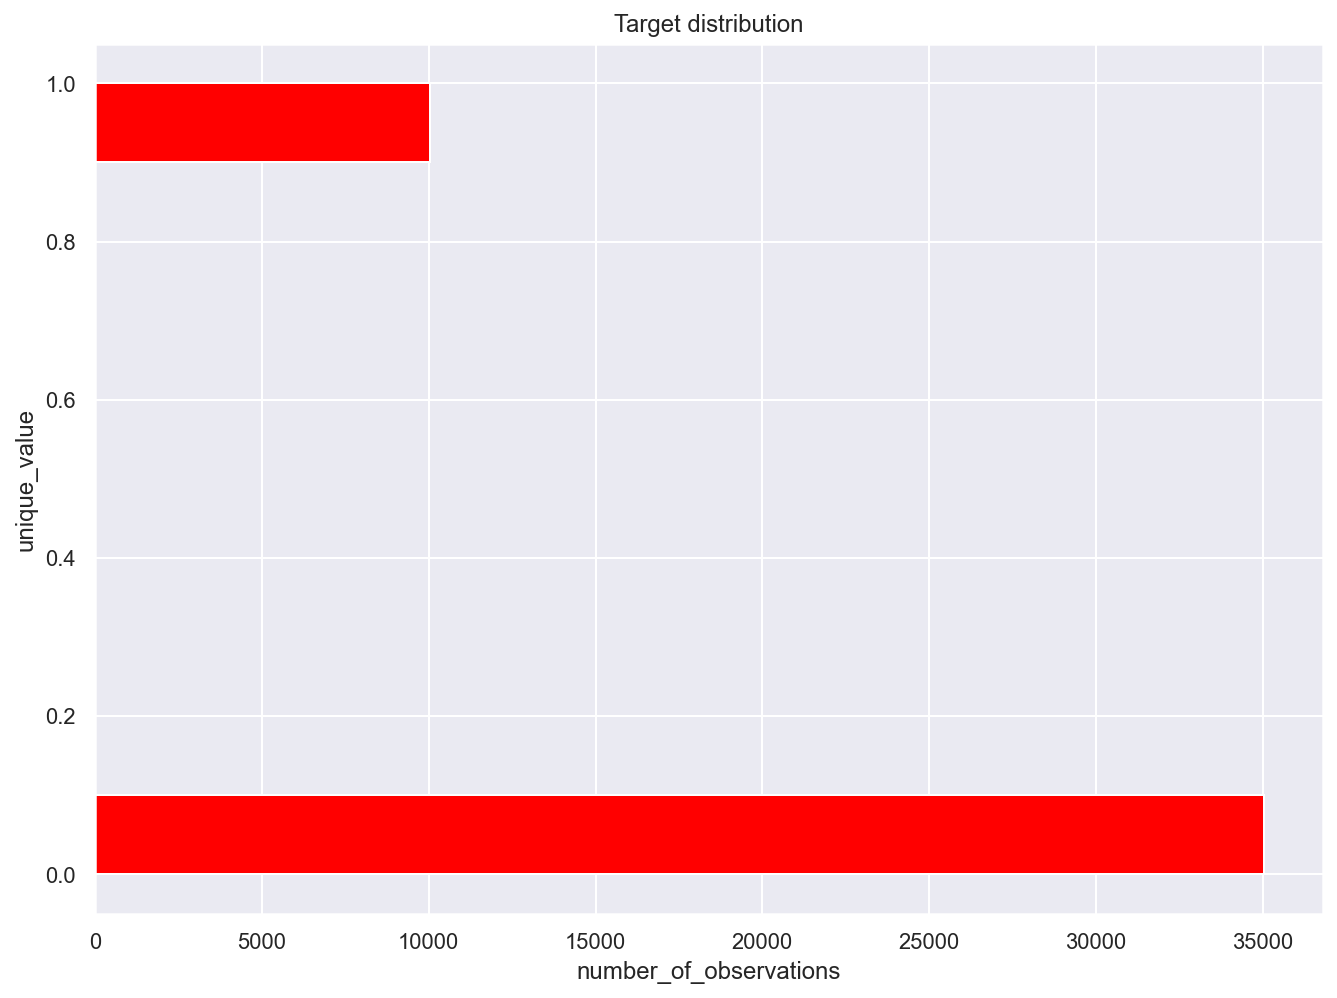

In [35]:
ax = data["SeriousDlqin2yrs"].hist(orientation="horizontal", color="red")
ax.set_xlabel("number_of_observations")
ax.set_ylabel("unique_value")
ax.set_title("Target distribution")

print("Distribution of the target:")
data["SeriousDlqin2yrs"].value_counts() / data.shape[0]

In [36]:
independent_columns_names = [x for x in data if x != "SeriousDlqin2yrs"]
independent_columns_names

['age',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'DebtRatio',
 'NumberOfTimes90DaysLate',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'MonthlyIncome',
 'NumberOfDependents']

In [37]:
table = fill_nan(data)

In [38]:
X = table[independent_columns_names]
y = table["SeriousDlqin2yrs"]

In [39]:
def get_bootstrap_samples(data, n_samples):
    """Generate samples using bootstrapping."""
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples


def stat_intervals(stat, alpha):
    """Make an interval estimate."""
    boundaries = np.percentile(stat, [100 * alpha / 2.0, 100 * (1 - alpha / 2.0)])
    return boundaries


# Save the ages of those who let a delay
churn = data[data["SeriousDlqin2yrs"] == 1]["age"].values

# Set the random seed for reproducibility
np.random.seed(0)

# Generate bootstrap samples and calculate the mean for each sample
churn_mean_scores = [np.mean(sample) for sample in get_bootstrap_samples(churn, 1000)]

# Print the interval estimate for the sample means
print("Mean interval", stat_intervals(churn_mean_scores, 0.1))

Mean interval [45.71379414 46.12700479]


In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold

lr = LogisticRegression(random_state=5, class_weight="balanced")

parameters = {"C": (0.0001, 0.001, 0.01, 0.1, 1, 10)}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)

In [43]:
grid_search = GridSearchCV(lr, parameters, n_jobs=-1, cv=skf, scoring="roc_auc",verbose=1)
grid_search = grid_search.fit(X, y)
grid_search.best_estimator_

Fitting 5 folds for each of 6 candidates, totalling 30 fits


LogisticRegression(C=0.001, class_weight='balanced', random_state=5)

In [44]:
grid_search.cv_results_["std_test_score"]

array([0.00729216, 0.00813756, 0.00793691, 0.00516308, 0.00740281,
       0.00517454])

In [45]:
from sklearn.preprocessing import StandardScaler

lr = LogisticRegression(C=0.001, random_state=5, class_weight="balanced")
scal = StandardScaler()
lr.fit(scal.fit_transform(X), y)

pd.DataFrame(
    {"feat": independent_columns_names, "coef": lr.coef_.flatten().tolist()}
).sort_values(by="coef", ascending=False)

,feat,coef
1,NumberOfTime30-59DaysPastDueNotWorse,0.723427
3,NumberOfTimes90DaysLate,0.516788
4,NumberOfTime60-89DaysPastDueNotWorse,0.193558
6,NumberOfDependents,0.101443
2,DebtRatio,-0.024096
5,MonthlyIncome,-0.163146
0,age,-0.416702


In [47]:
print((np.exp(lr.coef_[0]) / np.sum(np.exp(lr.coef_[0])))[2]) ##softmax function calcualtes how much debtratio affects prediction

0.1142637528306527


In [48]:
lr = LogisticRegression(C=0.001, random_state=5, class_weight="balanced")
lr.fit(X, y)

pd.DataFrame(
    {"feat": independent_columns_names, "coef": lr.coef_.flatten().tolist()}
).sort_values(by="coef", ascending=False)

,feat,coef
1,NumberOfTime30-59DaysPastDueNotWorse,0.477648
3,NumberOfTimes90DaysLate,0.419586
4,NumberOfTime60-89DaysPastDueNotWorse,0.225008
6,NumberOfDependents,0.131974
5,MonthlyIncome,-0.000010
2,DebtRatio,-0.000028
0,age,-0.013766


In [52]:
np.exp(lr.coef_[0][0]*20)

0.75932531536672

In [53]:
from sklearn.ensemble import RandomForestClassifier

In [54]:
rf = RandomForestClassifier(
    n_estimators=100, n_jobs=-1, random_state=42, class_weight="balanced"
)

In [55]:
parameters = {
    "max_features": [1, 2, 4],
    "min_samples_leaf": [3, 5, 7, 9],
    "max_depth": [5, 10, 15],
}

In [57]:
%%time
rf_grid_search = GridSearchCV(
    rf, parameters, n_jobs=-1, scoring="roc_auc", cv=skf, verbose=True
)
rf_grid_search = rf_grid_search.fit(X, y)
print(rf_grid_search.best_score_ - grid_search.best_score_)




Fitting 5 folds for each of 36 candidates, totalling 180 fits
0.026820670654852385
CPU times: user 3.54 s, sys: 288 ms, total: 3.83 s
Wall time: 1min 11s


In [58]:
independent_columns_names[
    np.argmin(rf_grid_search.best_estimator_.feature_importances_)
]

'NumberOfDependents'

In [59]:
pd.DataFrame(
    {
        "feat": independent_columns_names,
        "coef": rf_grid_search.best_estimator_.feature_importances_,
    }
).sort_values(by="coef", ascending=False)

,feat,coef
1,NumberOfTime30-59DaysPastDueNotWorse,0.301011
3,NumberOfTimes90DaysLate,0.278447
4,NumberOfTime60-89DaysPastDueNotWorse,0.156217
0,age,0.115587
2,DebtRatio,0.076118
5,MonthlyIncome,0.058277
6,NumberOfDependents,0.014343


In [60]:
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_score

parameters = {
    "max_features": [2, 3, 4],
    "max_samples": [0.5, 0.7, 0.9],
    "base_estimator__C": [0.0001, 0.001, 0.01, 1, 10, 100],
}

In [66]:
bg = BaggingClassifier(
    LogisticRegression(class_weight="balanced"),
    n_estimators = 100,
    n_jobs=-1,
    random_state=42
    
)

r_grid_search = RandomizedSearchCV(
    bg,
    parameters,
    n_jobs=-1,
    scoring="roc_auc",
    cv=skf,
    n_iter=20,
    random_state=1,
    verbose=True
)

r_grid_search = r_grid_search.fit(X,y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [67]:
r_grid_search.best_score_

0.8087951623513827